# Example of doing an image rotation in 2D and comparing against Scipy

This example demonstrates how to create a basic rotation using the TensorSpline API and comparing against Scipy's.

In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import ndimage, datasets

from splineops.interpolate.tensorspline import TensorSpline

## Calculate Inscribed Rectangle Bounds from Image

Calculate the bounds for the largest rectangle that can be inscribed within a circle, which itself is inscribed within the original image, based on the image array directly.

In [2]:
def calculate_inscribed_rectangle_bounds_from_image(image):
    """
    Calculate the bounds for the largest rectangle that can be inscribed
    within a circle, which itself is inscribed within the original image,
    based on the image array directly.

    The rectangle and the circle are centered within the original image.

    Parameters:
    - image: The input image as a 2D or 3D numpy array.

    Returns:
    - A tuple (x_min, y_min, x_max, y_max) representing the bounds for cropping.
    """
    # Extract image dimensions
    height, width = image.shape[:2]

    # Calculate the radius of the inscribed circle
    radius = min(width, height) / 2

    # The side length of the square (largest inscribed rectangle in a circle)
    side_length = radius * np.sqrt(2)

    # Calculate the center of the image
    cx, cy = width / 2, height / 2

    # Calculate the bounds of the largest inscribed rectangle
    x_min = int(cx - side_length / 2)
    y_min = int(cy - side_length / 2)
    x_max = int(cx + side_length / 2)
    y_max = int(cy + side_length / 2)

    return np.array([x_min, y_min, x_max, y_max])

## Crop Image to Bounds

Crop an image to the specified bounds.

In [3]:
def crop_image_to_bounds(image, bounds):
    """
    Crop an image to the specified bounds.

    Parameters:
    - image: The input image as a 2D numpy array.
    - bounds: An array of (x_min, y_min, x_max, y_max) defining the crop bounds,
              where these values are absolute pixel coordinates in the image.

    Returns:
    - Cropped image as a 2D numpy array.
    """
    x_min, y_min, x_max, y_max = bounds
    return image[y_min:y_max, x_min:x_max]

## Calculate Signal-to-Noise Ratio (SNR)

Compute the Signal-to-Noise Ratio (SNR) between the original and modified images.

In [4]:
def calculate_snr(original, modified):
    """
    Compute the Signal-to-Noise Ratio (SNR) between the original and modified images.

    Parameters:
    - original: The original image as a 2D numpy array.
    - modified: The modified (rotated) image as a 2D numpy array.

    Returns:
    - SNR value as a float.
    """
    original_normalized = original / 255.0 if original.max() > 1 else original
    processed_normalized = modified / 255.0 if modified.max() > 1 else modified
    noise = original_normalized - processed_normalized
    mean_signal = np.mean(original_normalized)
    variance_noise = np.var(noise)
    epsilon = 1e-3
    snr = 10 * np.log10((mean_signal**2) / (variance_noise + epsilon))
    return snr

## Calculate Mean Squared Error (MSE)

Compute the Mean Squared Error (MSE) between the original and modified images.

In [5]:
def calculate_mse(original, modified):
    """
    Compute the Mean Squared Error (MSE) between the original and modified images.

    Parameters:
    - original: The original image as a 2D numpy array.
    - modified: The modified (rotated) image as a 2D numpy array.

    Returns:
    - MSE value as a float.
    """
    mse = np.mean((original - modified) ** 2)
    return mse

## Rotate Image and Crop using SplineOps

Rotate an image by a specified angle using the splineops library's TensorSpline method and crop the result.

In [6]:
def rotate_image_and_crop_splineops(image, angle, degree=3, mode="zero", iterations=1):
    """
    Rotate an image by a specified angle using the splineops library's TensorSpline method and crop the result.

    Parameters:
    - image: The input image as a 2D numpy array.
    - angle: The rotation angle in degrees.
    - degree: The degree of the spline (0-7).
    - mode: The mode for handling boundaries (default is "zero").
    - iterations: The number of iterations to apply the rotation.

    Returns:
    - Rotated image as a 2D numpy array.
    """
    dtype = image.dtype
    ny, nx = image.shape
    xx = np.linspace(0, nx - 1, nx, dtype=dtype)
    yy = np.linspace(0, ny - 1, ny, dtype=dtype)
    data = np.ascontiguousarray(image, dtype=dtype)
    rotated_image = data

    degree = max(0, min(degree, 7))
    basis = f"bspline{degree}"

    for _ in range(iterations):
        tensor_spline = TensorSpline(
            data=rotated_image, coordinates=(yy, xx), bases=basis, modes=mode
        )
        angle_rad = np.radians(-angle)
        cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
        original_center_x, original_center_y = (nx - 1) / 2.0, (ny - 1) / 2.0
        oy, ox = np.ogrid[0:ny, 0:nx]
        ox = ox - original_center_x
        oy = oy - original_center_y

        nx_coords = cos_angle * ox + sin_angle * oy + original_center_x
        ny_coords = -sin_angle * ox + cos_angle * oy + original_center_y

        eval_coords = ny_coords.flatten(), nx_coords.flatten()
        interpolated_values = tensor_spline(coordinates=eval_coords, grid=False)
        rotated_image = interpolated_values.reshape(ny, nx)

    return rotated_image

## Rotate Image and Crop using SciPy

Rotate an image by a specified angle using SciPy's ndimage.rotate function and crop the result.

In [7]:
def rotate_image_and_crop_scipy(image, angle, order=3, iterations=5):
    """
    Rotate an image by a specified angle using SciPy's ndimage.rotate function and crop the result.

    Parameters:
    - image: The input image as a 2D numpy array.
    - angle: The rotation angle in degrees.
    - order: The order of the spline (0-5).
    - iterations: The number of iterations to apply the rotation.

    Returns:
    - Rotated image as a 2D numpy array.
    """
    rotated_image = image.copy()
    for _ in range(iterations):
        rotated_image = ndimage.rotate(
            rotated_image, angle, reshape=False, order=order, mode="constant", cval=0
        )
    return rotated_image

## Benchmark and Display Rotation

Perform a benchmark of the rotation operation for both SplineOps and SciPy libraries and display images.

In [8]:
def benchmark_and_display_rotation(image, angle, degree, iterations):
    """
    Perform a benchmark of the rotation operation for both splineops and SciPy libraries and display images.

    Parameters:
    - image: The input image as a 2D numpy array.
    - angle: The rotation angle in degrees.
    - degree: The degree of the spline (0-7).
    - iterations: The number of iterations to apply the rotation.
    """
    start_time_custom = time.time()
    custom_rotated_and_cropped_splineops = rotate_image_and_crop_splineops(
        image, angle, degree=degree, mode="zero", iterations=iterations
    )
    time_custom = time.time() - start_time_custom

    start_time_scipy = time.time()
    scipy_rotated_and_cropped = rotate_image_and_crop_scipy(
        image, angle, order=degree, iterations=iterations
    )
    time_scipy = time.time() - start_time_scipy

    bounds = calculate_inscribed_rectangle_bounds_from_image(image)
    image_cropped = crop_image_to_bounds(image, bounds)
    custom_rotated_and_cropped_splineops = crop_image_to_bounds(
        custom_rotated_and_cropped_splineops, bounds
    )
    scipy_rotated_and_cropped = crop_image_to_bounds(scipy_rotated_and_cropped, bounds)

    snr_splineops = calculate_snr(image_cropped, custom_rotated_and_cropped_splineops)
    snr_scipy = calculate_snr(image_cropped, scipy_rotated_and_cropped)
    mse_splineops = calculate_mse(image_cropped, custom_rotated_and_cropped_splineops)
    mse_scipy = calculate_mse(image_cropped, scipy_rotated_and_cropped)

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    axes[0].imshow(image_cropped, cmap="gray")
    axes[0].set_title("Original Image")
    axes[1].imshow(custom_rotated_and_cropped_splineops, cmap="gray")
    axes[1].set_title(
        f"SplineOps Rotated\nSNR: {snr_splineops:.2f}dB, MSE: {mse_splineops:.2e}\nAngle: {angle}°, Iter: {iterations}\nDegree: {degree}, Time: {time_custom:.2f}s"
    )
    axes[2].imshow(scipy_rotated_and_cropped, cmap="gray")
    axes[2].set_title(
        f"SciPy Rotated\nSNR: {snr_scipy:.2f}dB, MSE: {mse_scipy:.2e}\nAngle: {angle}°, Iter: {iterations}\nDegree: {degree}, Time: {time_scipy:.2f}s"
    )

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, top=0.95, bottom=0.05)
    plt.show()

## Load Image and Perform Rotations

Load the image, perform rotations using both SplineOps and SciPy methods, and display the results.

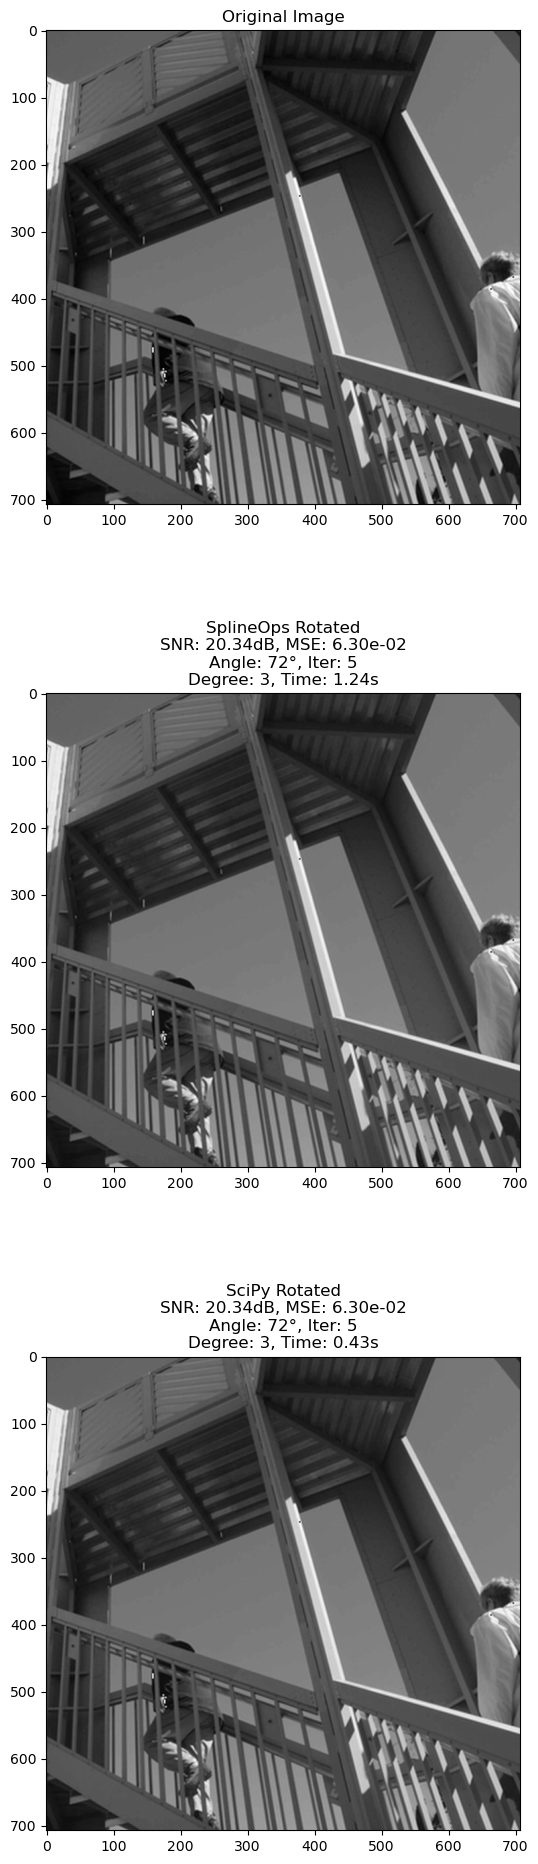

In [9]:
# Image size, Rotation angle and iterations and degree of spline interpolation
size = 1000
angle = 72  # 72
iterations = 5  # 5
degree = 3

# Load and resize the ascent image
image = datasets.ascent()
image_resized = ndimage.zoom(
    image, (size / image.shape[0], size / image.shape[1]), order=degree
)

# Convert to float32
image_resized = image_resized.astype(np.float32)

# Benchmark and display rotation results
benchmark_and_display_rotation(image_resized, angle, degree, iterations)